# GAN 

In [11]:
import numpy as np
import pandas as pd
import argparse
import os
import numpy as np
import math
import sys
import cv2
import torchvision.transforms as tt
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [13]:
# downloading the MNIST
mnist = datasets.MNIST(root ='data',
                       download = True,
                       transform = tt.Compose([tt.Resize(64), tt.ToTensor(), tt.Normalize([0.5], [0.5])]))

data_loader = DataLoader(mnist, batch_size = 100, shuffle = True, num_workers=2)

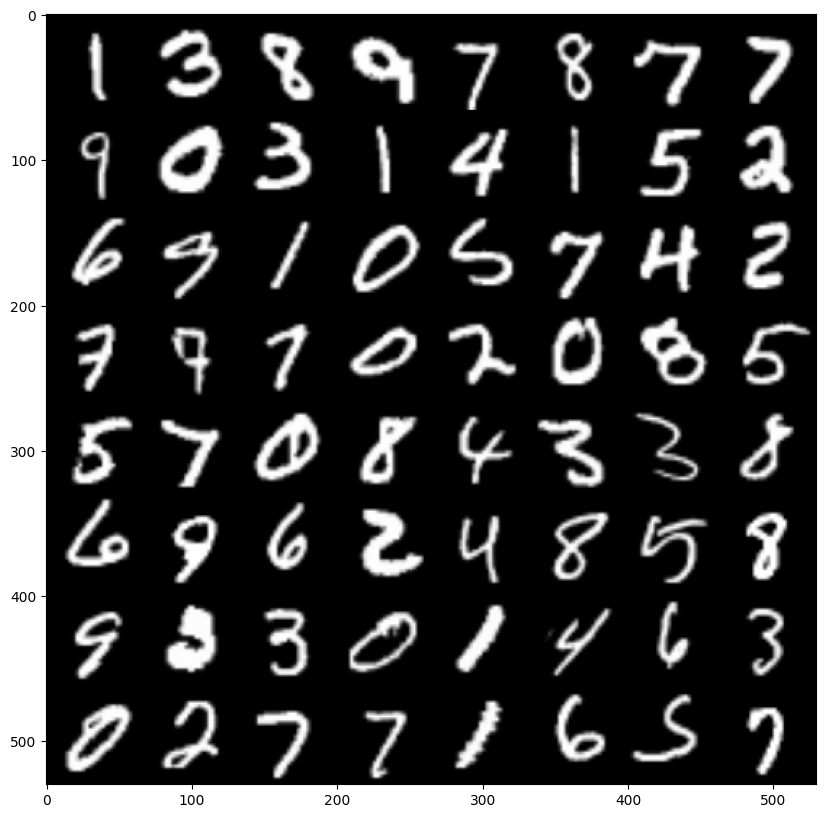

In [14]:
import torchvision

iter = __builtins__.iter
# ground data
ground_data = next(iter(data_loader))

plt.figure(figsize=(10, 10))
# plt.axis("off")

# display ground data
grid_image = torchvision.utils.make_grid(ground_data[0].to(device)[:64], padding=2, normalize=True).cpu()

plt.imshow(np.transpose(grid_image, (1, 2, 0)))
plt.show()


In [15]:
img_shape = (1, 64, 64)

# Creating Generator and Discriminator 

In [33]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img
    
# creating the discriminator/critic => No sigmoid activation function; just outputs a real number
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 1),
            # no sigmoid activation function here
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        is_real = self.model(img_flat)
        return is_real

generator = Generator(z_dim=100).to(device)
discriminator = Discriminator().to(device)

In [35]:
from torchviz import make_dot

model = Generator(z_dim=100)
# dummy input
x = torch.randn(1, 128)

make_dot(model(x), params=dict(model.named_parameters()))




RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x128 and 100x128)

In [17]:
# Optimizers for generator and discriminator
learning_rate = 0.0002 # recommended by the authors of the DCGAN paper
betas = (0.5, 0.999) # recommended by the authors of the DCGAN paper

# optimizers: adam optimizer for both generator and discriminator
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)

In [18]:
def calculate_penalty(dis, real_imgs, fake_imgs, lamda):
    # Random weight term for interpolation between real and fake samples
    batch_size = real_imgs.size(0)
    w_0 = torch.FloatTensor(np.random.random((batch_size , 1, 1, 1))).to(device)

    # Interpolate real with fake images
    interpolated = (w_0 * real_imgs + (1 - w_0) * fake_imgs).requires_grad_(True).to(device)
    validity_interpolated = dis(interpolated).to(device)  

    # Create a tensor of ones for the gradient computation
    fake = Variable(torch.FloatTensor(real_imgs.shape[0], 1).fill_(1.0), requires_grad=False).to(device)

    # Compute gradients of the critic's output w.r.t. the interpolated samples
    gradients = autograd.grad(
        outputs=validity_interpolated,
        inputs=interpolated,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Flatten the gradients
    gradients = gradients.view(gradients.size(0), -1)

    # Compute the gradient penalty
    grad_pen = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    penalty = lamda * grad_pen

    return penalty

    

In [19]:
import seaborn as sns

def plot_discriminator_outputs(real_output, fake_output):
    plt.figure(figsize=(10, 5))
    sns.histplot(real_output.cpu().detach().numpy(), color="blue", label="Real Images", kde=True)
    sns.histplot(fake_output.cpu().detach().numpy(), color="red", label="Fake Images", kde=True)
    plt.title("Discriminator Outputs for Real and Fake Images")
    plt.xlabel("Discriminator Output")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [22]:
import matplotlib.pyplot as plt
num_epochs = 100

epochs = list(range(num_epochs))
dis_losses = []  # Store discriminator losses
gen_losses = []  # Store generator losses

gradient_penalties = []

In [23]:
# TRAINING
num_epochs = 100
lamda = 10
delta_updates = 5 #  how many times the discriminator is updated before the generator is updated
iter = 0

# create a directory to save the images if it does not exist
os.makedirs("images_formatted_", exist_ok=True)

for epoch in range(num_epochs):
    for i, (image, _) in enumerate(data_loader):

        # Configure input
        real_imgs = Variable(image.type(torch.cuda.FloatTensor)).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_dis.zero_grad()

        # Sample noise as generator input
        z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (image.shape[0], 100)))).to(device)

        # Generate a batch of images
        fake_imgs =Variable(generator(z).to(device))

        # Real images
        real_img_is_real = discriminator(real_imgs)
        # Fake images
        fake_img_is_real = discriminator(fake_imgs)

        # Get gradient penalty
        penalty = calculate_penalty(discriminator, real_imgs.data, fake_imgs.data, lamda)   

        # Discriminator loss = wassertein distance + penalty
        wasserstein_dis = torch.mean(fake_img_is_real) - torch.mean(real_img_is_real)
        dis_loss = wasserstein_dis + penalty

        # Backpropagation for discriminator
        dis_loss.backward()
        optimizer_dis.step()

        # clear the gradients of the generator
        optimizer_gen.zero_grad()

        # train the generator less frequently than the discriminator
        if i % delta_updates == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z).to(device)


            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_img_is_real = discriminator(fake_imgs)
            gen_loss = -torch.mean(fake_img_is_real)

            # Backpropagation for generator
            gen_loss.backward()
            optimizer_gen.step()
    dis_losses.append(dis_loss.item())
    gen_losses.append(gen_loss.item())
    gradient_penalties.append(penalty.item())
    print(f"Epoch {epoch}/{num_epochs} --------  D loss: {dis_loss.item()} ------ G loss: {gen_loss.item()}")

    save_image(fake_imgs.data[:25], "images_formatted_/%d.png" % epoch, nrow=5, normalize=True)


Epoch 0/100 --------  D loss: -7.3869123458862305 ------ G loss: -0.7602612972259521
Epoch 1/100 --------  D loss: -7.134629726409912 ------ G loss: -1.6278481483459473
Epoch 2/100 --------  D loss: -6.541325569152832 ------ G loss: 0.1532403826713562
Epoch 3/100 --------  D loss: -7.002318382263184 ------ G loss: -0.4988654851913452
Epoch 4/100 --------  D loss: -6.160597801208496 ------ G loss: -0.7697454690933228
Epoch 5/100 --------  D loss: -6.38010311126709 ------ G loss: -2.5298008918762207
Epoch 6/100 --------  D loss: -6.649652004241943 ------ G loss: -2.2294070720672607
Epoch 7/100 --------  D loss: -5.23613166809082 ------ G loss: -2.8739161491394043
Epoch 8/100 --------  D loss: -5.607937335968018 ------ G loss: -1.189517617225647
Epoch 9/100 --------  D loss: -5.638406753540039 ------ G loss: -2.4837584495544434
Epoch 10/100 --------  D loss: -4.95648717880249 ------ G loss: -5.014315605163574
Epoch 11/100 --------  D loss: -5.619693756103516 ------ G loss: -2.317898273468

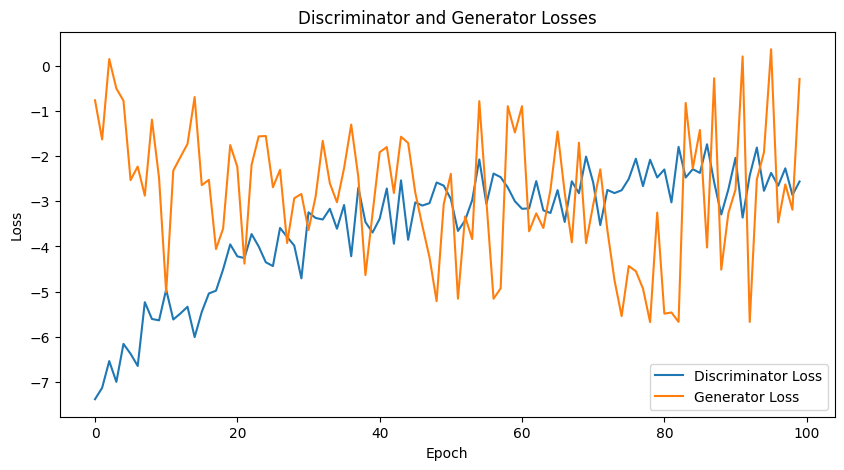

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, dis_losses, label="Discriminator Loss")
plt.plot(epochs, gen_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator and Generator Losses")
plt.legend()
plt.show()

In [161]:
# save generator model and discriminator model to pkl files
torch.save(generator.state_dict(), 'models/generator.pkl')
torch.save(discriminator.state_dict(), 'models/discriminator.pkl')

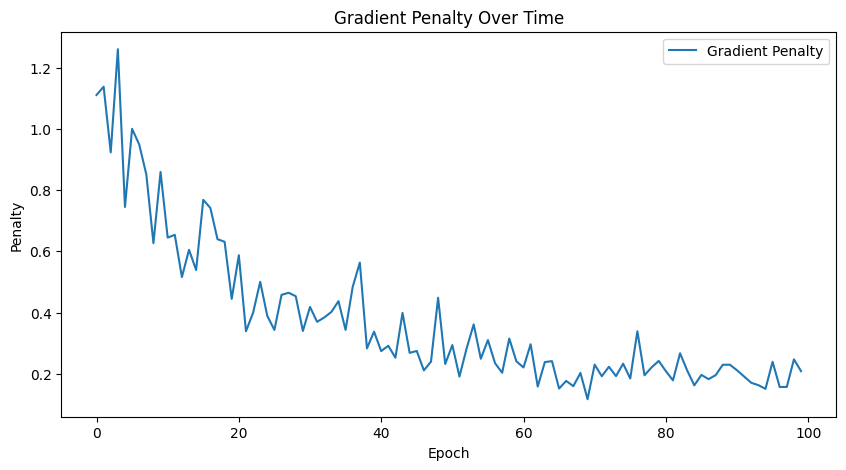

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, gradient_penalties, label="Gradient Penalty")
plt.xlabel("Epoch")
plt.ylabel("Penalty")
plt.title("Gradient Penalty Over Time")
plt.legend()
plt.show()

# Classifier

### Imports and intial setup

In [ ]:
import torch

from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import torch.nn as nn

from torch import optim
from torch.autograd import Variable

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load MNIST dataset

In [ ]:
MNIST_path='data'

train_data=datasets.MNIST(
    root=MNIST_path,
    train=True,
    transform=ToTensor(),
    download=True,
)


test_data=datasets.MNIST(
    root=MNIST_path,
    train=False,
    transform=ToTensor()
)


In [ ]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


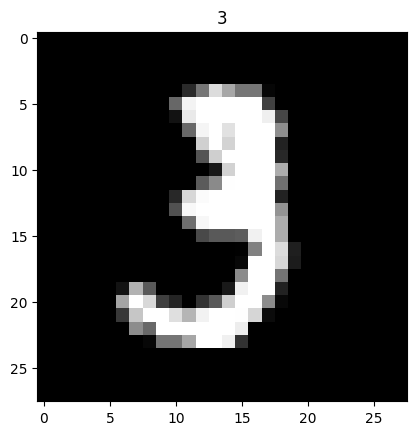

In [ ]:
plt.imshow(train_data.data[10], cmap='gray')
plt.title('%i' % train_data.targets[10])
plt.show()

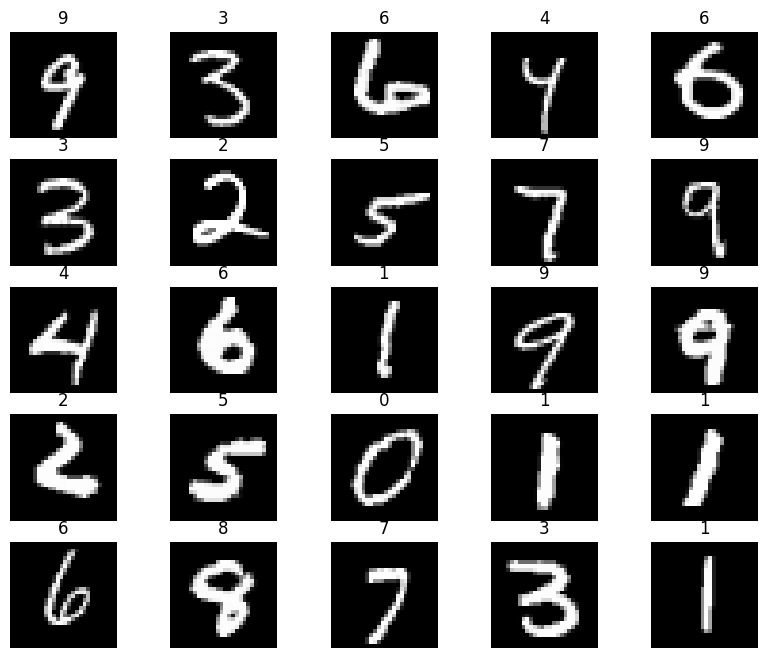

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1f54e939660>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1f54e99a860>}

### Classfication Model setup and training

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=36,           
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.BatchNorm2d(36),            # Batch normalization after conv1
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
            nn.Dropout(p=0.25)             # Dropout with 25% probability after conv1
        )
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(36, 32, 5, 1, 2),     
            nn.BatchNorm2d(32),            # Batch normalization after conv2
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
            nn.Dropout(p=0.25)             # Dropout with 25% probability after conv2
        )
        
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),    # Added intermediate fully connected layer
            nn.ReLU(),
            nn.Dropout(p=0.5),             # Dropout with 50% probability
            nn.Linear(128, 10)             # Output layer for 10 classes
        )


        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization



In [ ]:
cnn=CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(36, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(cnn.parameters(), lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [ ]:
num_epochs = 10

#Remember to run on GPU

def train(num_epochs, cnn, loaders):
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        pass
    pass

train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.4941
Epoch [1/10], Step [200/600], Loss: 0.4817
Epoch [1/10], Step [300/600], Loss: 0.3732
Epoch [1/10], Step [400/600], Loss: 0.3501
Epoch [1/10], Step [500/600], Loss: 0.1874
Epoch [1/10], Step [600/600], Loss: 0.1397
Epoch [2/10], Step [100/600], Loss: 0.3296
Epoch [2/10], Step [200/600], Loss: 0.1660
Epoch [2/10], Step [300/600], Loss: 0.2412
Epoch [2/10], Step [400/600], Loss: 0.2571
Epoch [2/10], Step [500/600], Loss: 0.2804
Epoch [2/10], Step [600/600], Loss: 0.2132
Epoch [3/10], Step [100/600], Loss: 0.1480
Epoch [3/10], Step [200/600], Loss: 0.2106
Epoch [3/10], Step [300/600], Loss: 0.1898
Epoch [3/10], Step [400/600], Loss: 0.1353
Epoch [3/10], Step [500/600], Loss: 0.1202
Epoch [3/10], Step [600/600], Loss: 0.0857
Epoch [4/10], Step [100/600], Loss: 0.0764
Epoch [4/10], Step [200/600], Loss: 0.0896
Epoch [4/10], Step [300/600], Loss: 0.1158
Epoch [4/10], Step [400/600], Loss: 0.1218
Epoch [4/10], Step [500/600], Loss: 0.0577
Epoch [4/10

### Classification of MNIST test set

In [ ]:
def test():
  cnn.eval()
  with torch.no_grad():
    correct=0
    total=0
    for images, labels in loaders['test']:
      test_output,last_layer=cnn(images)
      pred_y=torch.max(test_output,1)[1].data.squeeze()
      accuracy=(pred_y==labels).sum().item()/float(labels.size(0))
      pass
    print('Test Acc %.2f' % accuracy)
    pass


test()

Test Acc 0.98


In [ ]:
# Load random 100 number (Since the test set is shuffled)

S0 = next(iter(loaders['test']))
imgs, lbls = S0
actual_number = lbls[:100].numpy()

In [ ]:
test_output,last_layer=cnn(imgs[:100])
pred_y=torch.max(test_output,1)[1].data.numpy().squeeze()

print(f'Prediction number {pred_y}')
print(f'Actual number {actual_number}')

Prediction number [0 7 8 7 1 9 0 8 2 9 5 7 6 1 4 7 7 3 2 2 8 9 7 5 0 0 0 3 4 9 8 9 0 2 2 3 7
 8 4 2 0 1 4 4 3 1 5 4 8 6 3 9 8 5 6 4 1 3 7 5 2 2 0 0 0 0 1 8 7 0 7 1 7 8
 1 5 4 1 0 0 0 8 7 8 0 3 3 4 6 4 2 6 5 8 3 6 2 4 7 5]
Actual number [0 7 8 7 1 9 0 8 2 9 5 7 6 1 4 7 7 3 2 2 8 9 7 5 0 0 0 3 4 9 8 9 0 2 2 3 7
 8 4 2 0 1 4 4 3 1 5 4 8 6 3 9 8 5 6 4 1 3 7 5 2 2 0 0 0 0 1 8 7 0 7 1 7 8
 1 5 4 1 0 0 0 8 7 8 0 3 3 4 6 4 2 6 5 8 3 6 2 4 7 5]


In [ ]:
# get the accuracy of the model based on the two lists 
def get_accuracy(pred_y, actual_number):
    accuracy = sum(pred_y == actual_number) / len(pred_y)
    # percentage of correct prediction
    return f"{accuracy * 100:.2f}%"

get_accuracy(pred_y, actual_number)

'100.00%'

### Classification of custom dataset

In [ ]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class FakeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for label in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, label)
            for img_name in os.listdir(folder_path):
                if img_name.endswith('.png'): 
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(int(label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # convert image to grayscale
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, img_path  # Also return image path for reference

# Apply necessary transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# Load the custom dataset
S1 = FakeDataset(root_dir='wgan/dataset_2/Fake_Digits', transform=transform)
custom_loader = DataLoader(S1, batch_size=1, shuffle=False)  # Batch size set to 1 for individual processing

# Test the model on the custom dataset and print predictions
def test_custom_dataset(model, loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, img_paths in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Increment total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print the predicted and actual labels
            print(f'Image: {img_paths[0]} | Predicted: {predicted.item()} | Actual: {labels.item()}')

    accuracy = 100 * correct / total
    print(f'\nAccuracy on custom dataset: {accuracy:.2f}%')

# Assuming your model is already trained and loaded
cnn.to(device)
test_custom_dataset(cnn, custom_loader)


Image: wgan/dataset_2/Fake_Digits\0\042.png | Predicted: 0 | Actual: 0
Image: wgan/dataset_2/Fake_Digits\0\049.png | Predicted: 0 | Actual: 0
Image: wgan/dataset_2/Fake_Digits\0\053.png | Predicted: 0 | Actual: 0
Image: wgan/dataset_2/Fake_Digits\0\066.png | Predicted: 0 | Actual: 0
Image: wgan/dataset_2/Fake_Digits\0\067.png | Predicted: 0 | Actual: 0
Image: wgan/dataset_2/Fake_Digits\0\076.png | Predicted: 0 | Actual: 0
Image: wgan/dataset_2/Fake_Digits\0\083.png | Predicted: 0 | Actual: 0
Image: wgan/dataset_2/Fake_Digits\0\085.png | Predicted: 0 | Actual: 0
Image: wgan/dataset_2/Fake_Digits\0\086.png | Predicted: 0 | Actual: 0
Image: wgan/dataset_2/Fake_Digits\0\091.png | Predicted: 0 | Actual: 0
Image: wgan/dataset_2/Fake_Digits\1\002.png | Predicted: 1 | Actual: 1
Image: wgan/dataset_2/Fake_Digits\1\034.png | Predicted: 1 | Actual: 1
Image: wgan/dataset_2/Fake_Digits\1\035.png | Predicted: 1 | Actual: 1
Image: wgan/dataset_2/Fake_Digits\1\056.png | Predicted: 1 | Actual: 1
Image:

In [ ]:
# save the classifier as c.pkl
torch.save(cnn.state_dict(), 'wgan/models/C.pkl')